In [1]:
#dataframes
import pandas as pd
import h5py

# user defined functions

#speedup
import multiprocessing as mp

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import signal
import scipy 
import scipy.stats as st
from scipy.stats import kurtosis
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform
from scipy import fft

#plots
import pylab as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib
from figurefirst import FigureLayout,mpl_functions
import figurefirst
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
import figurefirst as fifi
from IPython.display import display,SVG

import networkx as nx
import community.community_louvain as community_louvain # pip install community

#misc
import cairosvg
import time
np.set_printoptions(suppress=True)
import fly_plot_lib.plot as fpl
# matplotlib.rcParams['font.family'] = [ 'sans-serif']
FS=7
dir = '~/DataAnalysis/data/Sprints/HighRes/'

In [2]:
df1 = pd.read_hdf(dir+'Windy/WindyMASigned.h5')
df2 = pd.read_hdf(dir+'NotWindy/NotWindyMASigned.h5')
df3 = pd.read_hdf(dir+'Forest/ForestMASigned.h5')

In [3]:
def fft_of_data(data,dt):
    data = data-np.mean(data)
    N = data.shape[0] # Length of data.
    try:
        yf = 2.0/N * np.abs(fft.fft(data)[0:N//2])
    except ZeroDivisionError:
        yf= 0

    xf = fft.fftfreq(N,dt)[:N//2]# Only take the first half of the data.

    return(xf, yf) # xf = frequency array. yf = amplitude or power.

def calculate_rotation_matrix(angle):
    c, s = np.cos(angle), np.sin(angle)
    return np.array([[c, -s], [s, c]])

def rotate_vector(vector, rotation_matrix):
    return np.dot(rotation_matrix, vector)

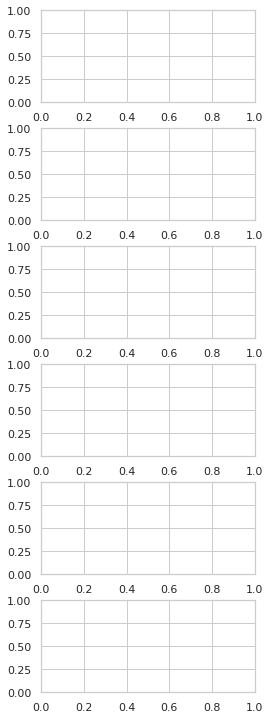

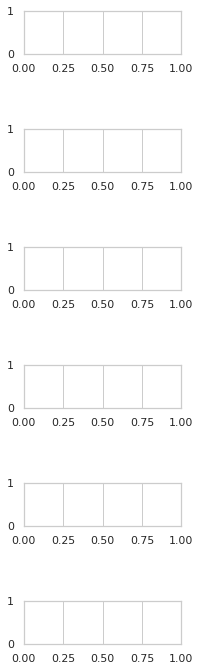

In [4]:
layout = fifi.svg_to_axes.FigureLayout('../../../../Figure/motionAnalysis.svg',
                                           autogenlayers=True, make_mplfigures=True, hide_layers=[])

## HWS

In [5]:
dat = pd.DataFrame() # Replace this with your actual data
dat=df1
heading='HWS'
# Your specific points and velocities
points = dat[['xsrc', 'ysrc']].values
velocities = dat[['gps_linear_x', 'gps_linear_y']].values

# Calculate the rotation angle for each point
angles = np.arctan2(points[:, 1], points[:, 0])

rotated_velocities = []

# Rotate each velocity to the body-fixed frame
for angle, velocity in zip(angles, velocities):
    rotation_matrix = calculate_rotation_matrix(angle)
    rotated_velocity = rotate_vector(velocity, rotation_matrix)
    rotated_velocities.append(rotated_velocity)

# Convert the list of rotated velocities to a numpy array
rotated_velocities = np.array(rotated_velocities)

# Extract the components of the velocities in the body-fixed frame
parallel_components = rotated_velocities[:, 0]
perpendicular_components = rotated_velocities[:, 1]

# Add the results to the DataFrame
dat['parallel'] = parallel_components
dat['perpendicular'] = perpendicular_components

dt = dat.time[1] - dat.time[0]

f_parallel, parallel_fft = fft_of_data(np.array(dat.parallel), dt)
f_perpendicular, perpendicular_fft = fft_of_data(np.array(dat.perpendicular), dt)

In [6]:
ax=layout.axes[('fig2','t1')]

lw=0.5
msize=3

ax.plot(dat.time,dat.parallel, linewidth=lw,rasterized=True)

ax.grid(False)
ax.set_xlim(0,2000)
ax.set_rasterization_zorder(-20)

mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={'left':4,'bottom':5}, 
                            smart_bounds=True,
                            xticks=[0,2000],
                            yticks = [-5.0,0,5.0],
                            linewidth=0.5)
ax.set_xticklabels([])
# ax.set_yticklabels([])

ax.set_ylabel('Parallel, m/s')
ax.yaxis.set_label_coords(-0.12, 0.5)

ax.set_xlabel('2000 secs')
ax.xaxis.set_label_coords(0.5, -0.2)

figurefirst.mpl_functions.set_fontsize(ax, FS)
layout.append_figure_to_layer(layout.figures['fig2'], 'fig2', cleartarget=True)
layout.write_svg('../../../../Figure/motionAnalysis.svg')

In [7]:
ax=layout.axes[('fig1','a1')]

lw=0.5
msize=3

ax.plot(f_parallel, np.abs(parallel_fft), linewidth=lw,rasterized=True)

ax.grid(False)
ax.set_xlim(0,1)
ax.set_rasterization_zorder(-20)

mpl_functions.adjust_spines(ax,['left'],
                            spine_locations={'left':4,'bottom':5}, 
                            smart_bounds=True,
                            xticks=[0,1],
                            yticks = [0,0.3],
                            linewidth=0.5)
ax.set_xticklabels([])

# ax.set_xlabel('1000 secs')
# ax.xaxis.set_label_coords(0.5, -0.2)

ax.set_ylabel('Parallel \nAmplitude, m/s')
ax.yaxis.set_label_coords(-0.04, 0.5)

figurefirst.mpl_functions.set_fontsize(ax, FS)
layout.append_figure_to_layer(layout.figures['fig1'], 'fig1', cleartarget=True)
layout.write_svg('../../../../Figure/motionAnalysis.svg')

In [8]:
ax=layout.axes[('fig2','t2')]

lw=0.5
msize=3

ax.plot(dat.time,dat.perpendicular, linewidth=lw,rasterized=True)

ax.grid(False)
ax.set_xlim(0,2000)
ax.set_rasterization_zorder(-20)

mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={'left':4,'bottom':5}, 
                            smart_bounds=True,
                            xticks=[0,2000],
                            yticks = [-5.0,0,5.0],
                            linewidth=0.5)
ax.set_xticklabels([])
# ax.set_yticklabels([])

ax.set_ylabel('Perpendicular, m/s')
ax.yaxis.set_label_coords(-0.12, 0.5)
ax.set_xlabel('2000 secs')
ax.xaxis.set_label_coords(0.5, -0.2)

figurefirst.mpl_functions.set_fontsize(ax, FS)
layout.append_figure_to_layer(layout.figures['fig2'], 'fig2', cleartarget=True)
layout.write_svg('../../../../Figure/motionAnalysis.svg')

In [9]:
ax=layout.axes[('fig1','a2')]

lw=0.5
msize=3

ax.plot(f_perpendicular, np.abs(perpendicular_fft), linewidth=lw,rasterized=True)

ax.grid(False)
ax.set_xlim(0,1)
ax.set_rasterization_zorder(-20)

mpl_functions.adjust_spines(ax,['left'],
                            spine_locations={'left':4,'bottom':5}, 
                            smart_bounds=True,
                            xticks=[0,1],
                            yticks = [0,0.3],
                            linewidth=0.5)
ax.set_xticklabels([])

# ax.set_xlabel('1000 secs')
# ax.xaxis.set_label_coords(0.5, -0.2)

ax.set_ylabel('Perpendicular \nAmplitude, m/s')
ax.yaxis.set_label_coords(-0.04, 0.5)

figurefirst.mpl_functions.set_fontsize(ax, FS)
layout.append_figure_to_layer(layout.figures['fig1'], 'fig1', cleartarget=True)
layout.write_svg('../../../../Figure/motionAnalysis.svg')

## LWS

In [10]:
dat = pd.DataFrame() # Replace this with your actual data
dat=df2
heading='LWS'
# Your specific points and velocities
points = dat[['xsrc', 'ysrc']].values
velocities = dat[['gps_linear_x', 'gps_linear_y']].values

# Calculate the rotation angle for each point
angles = np.arctan2(points[:, 1], points[:, 0])

rotated_velocities = []

# Rotate each velocity to the body-fixed frame
for angle, velocity in zip(angles, velocities):
    rotation_matrix = calculate_rotation_matrix(angle)
    rotated_velocity = rotate_vector(velocity, rotation_matrix)
    rotated_velocities.append(rotated_velocity)

# Convert the list of rotated velocities to a numpy array
rotated_velocities = np.array(rotated_velocities)

# Extract the components of the velocities in the body-fixed frame
parallel_components = rotated_velocities[:, 0]
perpendicular_components = rotated_velocities[:, 1]

# Add the results to the DataFrame
dat['parallel'] = parallel_components
dat['perpendicular'] = perpendicular_components

dt = dat.time[1] - dat.time[0]

f_parallel, parallel_fft = fft_of_data(np.array(dat.parallel), dt)
f_perpendicular, perpendicular_fft = fft_of_data(np.array(dat.perpendicular), dt)

In [11]:
ax=layout.axes[('fig2','t3')]

lw=0.5
msize=3

ax.plot(dat.time,dat.parallel, linewidth=lw,rasterized=True)

ax.grid(False)
ax.set_xlim(0,2000)
ax.set_rasterization_zorder(-20)

mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={'left':4,'bottom':5}, 
                            smart_bounds=True,
                            xticks=[0,2000],
                            yticks = [-5.0,0,5.0],
                            linewidth=0.5)
ax.set_xticklabels([])

ax.set_xlabel('2000 secs')
ax.xaxis.set_label_coords(0.5, -0.2)

figurefirst.mpl_functions.set_fontsize(ax, FS)
layout.append_figure_to_layer(layout.figures['fig2'], 'fig2', cleartarget=True)
layout.write_svg('../../../../Figure/motionAnalysis.svg')

In [12]:
ax=layout.axes[('fig1','a3')]

lw=0.5
msize=3

ax.plot(f_parallel, np.abs(parallel_fft), linewidth=lw,rasterized=True)

ax.grid(False)
ax.set_xlim(0,1)
ax.set_rasterization_zorder(-20)

mpl_functions.adjust_spines(ax,['left'],
                            spine_locations={'left':4,'bottom':5}, 
                            smart_bounds=True,
                            xticks=[0,1],
                            yticks = [0,0.1],
                            linewidth=0.5)
ax.set_xticklabels([])

# ax.set_xlabel('1000 secs')
# ax.xaxis.set_label_coords(0.5, -0.2)

ax.set_ylabel('Parallel \nAmplitude, m/s')
ax.yaxis.set_label_coords(-0.04, 0.5)

figurefirst.mpl_functions.set_fontsize(ax, FS)
layout.append_figure_to_layer(layout.figures['fig1'], 'fig1', cleartarget=True)
layout.write_svg('../../../../Figure/motionAnalysis.svg')

In [13]:
ax=layout.axes[('fig2','t4')]

lw=0.5
msize=3

ax.plot(dat.time,dat.perpendicular, linewidth=lw,rasterized=True)

ax.grid(False)
ax.set_xlim(0,2000)
ax.set_rasterization_zorder(-20)

mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={'left':4,'bottom':5}, 
                            smart_bounds=True,
                            xticks=[0,2000],
                            yticks = [-5.0,0,5.0],
                            linewidth=0.5)
ax.set_xticklabels([])

ax.set_xlabel('2000 secs')
ax.xaxis.set_label_coords(0.5, -0.2)

figurefirst.mpl_functions.set_fontsize(ax, FS)
layout.append_figure_to_layer(layout.figures['fig2'], 'fig2', cleartarget=True)
layout.write_svg('../../../../Figure/motionAnalysis.svg')

In [14]:
ax=layout.axes[('fig1','a4')]

lw=0.5
msize=3

ax.plot(f_perpendicular, np.abs(perpendicular_fft), linewidth=lw,rasterized=True)

ax.grid(False)
ax.set_xlim(0,1)
ax.set_rasterization_zorder(-20)

mpl_functions.adjust_spines(ax,['left'],
                            spine_locations={'left':4,'bottom':5}, 
                            smart_bounds=True,
                            xticks=[0,1],
                            yticks = [0,0.1],
                            linewidth=0.5)
ax.set_xticklabels([])

# ax.set_xlabel('1000 secs')
# ax.xaxis.set_label_coords(0.5, -0.2)

ax.set_ylabel('Perpendicular \nAmplitude, m/s')
ax.yaxis.set_label_coords(-0.04, 0.5)

figurefirst.mpl_functions.set_fontsize(ax, FS)
layout.append_figure_to_layer(layout.figures['fig1'], 'fig1', cleartarget=True)
layout.write_svg('../../../../Figure/motionAnalysis.svg')

## Forest

In [15]:
dat = pd.DataFrame() # Replace this with your actual data
dat=df3
heading='Forest'
# Your specific points and velocities
points = dat[['xsrc', 'ysrc']].values
velocities = dat[['gps_linear_x', 'gps_linear_y']].values

# Calculate the rotation angle for each point
angles = np.arctan2(points[:, 1], points[:, 0])

rotated_velocities = []

# Rotate each velocity to the body-fixed frame
for angle, velocity in zip(angles, velocities):
    rotation_matrix = calculate_rotation_matrix(angle)
    rotated_velocity = rotate_vector(velocity, rotation_matrix)
    rotated_velocities.append(rotated_velocity)

# Convert the list of rotated velocities to a numpy array
rotated_velocities = np.array(rotated_velocities)

# Extract the components of the velocities in the body-fixed frame
parallel_components = rotated_velocities[:, 0]
perpendicular_components = rotated_velocities[:, 1]

# Add the results to the DataFrame
dat['parallel'] = parallel_components
dat['perpendicular'] = perpendicular_components

dt = dat.time[1] - dat.time[0]

f_parallel, parallel_fft = fft_of_data(np.array(dat.parallel), dt)
f_perpendicular, perpendicular_fft = fft_of_data(np.array(dat.perpendicular), dt)

In [16]:
ax=layout.axes[('fig2','t5')]

lw=0.5
msize=3

ax.plot(dat.time,dat.parallel, linewidth=lw,rasterized=True)

ax.grid(False)
ax.set_xlim(0,2000)
ax.set_rasterization_zorder(-20)

mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={'left':4,'bottom':5}, 
                            smart_bounds=True,
                            xticks=[0,2000],
                            yticks = [-5.0,0,5.0],
                            linewidth=0.5)
ax.set_xticklabels([])
# ax.set_ylabel('Parallel, m/s')
# ax.yaxis.set_label_coords(-0.05, 0.5)

ax.set_xlabel('2000 secs')
ax.xaxis.set_label_coords(0.5, -0.2)

figurefirst.mpl_functions.set_fontsize(ax, FS)
layout.append_figure_to_layer(layout.figures['fig2'], 'fig2', cleartarget=True)
layout.write_svg('../../../../Figure/motionAnalysis.svg')

In [17]:
ax=layout.axes[('fig1','a5')]

lw=0.5
msize=3

ax.plot(f_parallel, np.abs(parallel_fft), linewidth=lw,rasterized=True)

ax.grid(False)
ax.set_xlim(0,1)
ax.set_rasterization_zorder(-20)

mpl_functions.adjust_spines(ax,['left'],
                            spine_locations={'left':4,'bottom':5}, 
                            smart_bounds=True,
                            xticks=[0,1],
                            yticks = [0,0.1],
                            linewidth=0.5)
ax.set_xticklabels([])

# ax.set_xlabel('1000 secs')
# ax.xaxis.set_label_coords(0.5, -0.2)

ax.set_ylabel('Parallel \nAmplitude, m/s')
ax.yaxis.set_label_coords(-0.04, 0.5)

figurefirst.mpl_functions.set_fontsize(ax, FS)
layout.append_figure_to_layer(layout.figures['fig1'], 'fig1', cleartarget=True)
layout.write_svg('../../../../Figure/motionAnalysis.svg')

In [18]:
ax=layout.axes[('fig2','t6')]

lw=0.5
msize=3

ax.plot(dat.time,dat.perpendicular, linewidth=lw,rasterized=True)

ax.grid(False)
ax.set_xlim(0,2000)
ax.set_rasterization_zorder(-20)

mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={'left':4,'bottom':5}, 
                            smart_bounds=True,
                            xticks=[0,2000],
                            yticks = [-5.0,0,5.0],
                            linewidth=0.5)
ax.set_xticklabels([])

# ax.set_ylabel('Perpendicular, m/s')
# ax.yaxis.set_label_coords(-0.05, 0.5)

ax.set_xlabel('2000 secs')
ax.xaxis.set_label_coords(0.5, -0.2)

figurefirst.mpl_functions.set_fontsize(ax, FS)
layout.append_figure_to_layer(layout.figures['fig2'], 'fig2', cleartarget=True)
layout.write_svg('../../../../Figure/motionAnalysis.svg')

In [19]:
ax=layout.axes[('fig1','a6')]

lw=0.5
msize=3

ax.plot(f_perpendicular, np.abs(perpendicular_fft), linewidth=lw,rasterized=True)

ax.grid(False)
ax.set_xlim(0,1)
ax.set_rasterization_zorder(-20)

mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={'left':4,'bottom':5}, 
                            smart_bounds=True,
                            xticks=[0,1],
                            yticks = [0,0.1],
                            linewidth=0.5)
# ax.set_xticklabels([0,1])

ax.set_xlabel('Frequency,Hz')
ax.xaxis.set_label_coords(0.5, -0.1)

ax.set_ylabel('Perpendicular \nAmplitude, m/s')
ax.yaxis.set_label_coords(-0.04, 0.5)

figurefirst.mpl_functions.set_fontsize(ax, FS)
layout.append_figure_to_layer(layout.figures['fig1'], 'fig1', cleartarget=True)
layout.write_svg('../../../../Figure/motionAnalysis.svg')